In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
data = pd.read_csv('./mnist_fashion/fashion-mnist_train.csv')
data = data.sample(frac=1).reset_index(drop=True)
y = np.zeros(data.shape[0])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, y,test_size=0.2)

In [21]:
X_test.label.value_counts()

1    1242
2    1241
3    1224
5    1213
0    1209
6    1187
8    1174
4    1172
9    1171
7    1167
Name: label, dtype: int64

In [23]:
X_train.label.value_counts()

7    4833
9    4829
4    4828
8    4826
6    4813
0    4791
5    4787
3    4776
2    4759
1    4758
Name: label, dtype: int64

In [24]:
X_train.to_csv('./mnist_fashion/train_dataset.csv',index=False)
X_test.to_csv('./mnist_fashion/valid_dataset.csv',index=False)

In [25]:
del X_train,X_test,data

In [28]:
del y_train, y_test, y

__________________________________________________________________---

In [44]:
class CustomDataset():
    
    def __init__(self,filepath):
        self.data = pd.read_csv(filepath)
        self.images = np.array(self.data.iloc[:,1:]).astype(float)
        self.labels = np.array(self.data.iloc[:,0])
        
    def __getitem__(self,index):
        return self.images[index], self.labels[index]
        
    def __len__(self):
        return (self.data.shape[0])

In [45]:
train_loader = DataLoader(CustomDataset('./mnist_fashion/train_dataset.csv'),
                         batch_size=64,
                         shuffle=True)
valid_loader = DataLoader(CustomDataset('./mnist_fashion/valid_dataset.csv'),
                         batch_size=64,
                         shuffle=True)

test_loader = DataLoader(CustomDataset('./mnist_fashion/fashion-mnist_test.csv'),
                         batch_size=64,
                         shuffle=True)

In [46]:
for i in train_loader:
    print i[0]
    break

tensor([[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.]], dtype=torch.float64)


In [47]:
i[0].shape

torch.Size([64, 784])

In [48]:
data_loaders = {"train": train_loader, "val": valid_loader}
data_lengths = {"train": train_loader.dataset.data.shape[0], "val": train_loader.dataset.data.shape[0]}

In [49]:
class FeedForwardNet(nn.Module):
    
    def __init__(self,input_size, num_classes):
        super(FeedForwardNet,self).__init__()
        # define all the components that will be used in the NN (these can be reused)
        self.fc1 = nn.Linear(input_size,496)
        self.fc2 = nn.Linear(496,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,32)
        self.fc5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.2)
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        out = self.dropout(out)
        out = self.fc5(out)
        return out

In [50]:
FNN = FeedForwardNet(784,10)
print FNN

FeedForwardNet(
  (fc1): Linear(in_features=784, out_features=496, bias=True)
  (fc2): Linear(in_features=496, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)


In [51]:
FNN.parameters

<bound method FeedForwardNet.parameters of FeedForwardNet(
  (fc1): Linear(in_features=784, out_features=496, bias=True)
  (fc2): Linear(in_features=496, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)>

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(FNN.parameters(), lr=0.001)

In [53]:
def save(filename):
    state = {'epoch': epoch + 1, 'state_dict': FNN.state_dict(),
             'optimizer': optimizer.state_dict(), 'train_loss': epoch_loss}
    torch.save(state, filename)

In [54]:
num_epoch =3
train_losses = []
valid_losses = []
for epoch in range( num_epoch):
    
    print('Epoch {}/{}'.format(epoch, num_epoch- 1))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            FNN.train() # Set model to training mode
        else:
            FNN.eval() # Set model to evaluate mode
        
        running_loss = 0.0
        # Iterate over data.
        for i, (images,labels) in enumerate(data_loaders[phase]):
            # torch can only train on Variable, so convert them to Variable
            images = Variable(images.float())
            labels = Variable(labels)
            
            outputs = FNN(images) # Forward pass: compute the output class given a image
            loss = criterion(outputs,labels) # Compute the loss: difference between the output class and the pre-given label
            
            optimizer.zero_grad() # clear gradients for next train
            if phase == 'train':
                loss.backward() # backpropagation, compute gradients
                optimizer.step() # apply gradients  and update the weights of hidden nodes
                
            running_loss += loss.data * images.size(0)
            
            if phase == 'train':
                if (i+1) % 100 == 0 :
                    print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, i+1, data_lengths[phase]//64, loss.data))
                    
        epoch_loss = running_loss / data_lengths[phase]
        if phase =='train':
            train_losses.append(epoch_loss)
            save('./mnist_fashion/checkpoint_epoch_'+str(epoch)+'_train_loss_'+str(epoch_loss)+'_'+'.pth.tar')
        if phase =='val':
            valid_losses.append(epoch_loss)
        print('Epoch [{}/{}]{} Loss: {:.4f}'.format(epoch+1, num_epoch,phase, epoch_loss))    

Epoch 0/2
----------
Epoch [1/3], Step [100/750], Loss: 0.8065
Epoch [1/3], Step [200/750], Loss: 0.4502
Epoch [1/3], Step [300/750], Loss: 0.7964
Epoch [1/3], Step [400/750], Loss: 0.3782
Epoch [1/3], Step [500/750], Loss: 0.6881
Epoch [1/3], Step [600/750], Loss: 0.6944
Epoch [1/3], Step [700/750], Loss: 0.7038
Epoch [1/3]train Loss: 0.6964
Epoch [1/3]val Loss: 0.1145
Epoch 1/2
----------
Epoch [2/3], Step [100/750], Loss: 0.3754
Epoch [2/3], Step [200/750], Loss: 0.4110
Epoch [2/3], Step [300/750], Loss: 0.5656
Epoch [2/3], Step [400/750], Loss: 0.6554
Epoch [2/3], Step [500/750], Loss: 0.3573
Epoch [2/3], Step [600/750], Loss: 0.4700
Epoch [2/3], Step [700/750], Loss: 0.3132
Epoch [2/3]train Loss: 0.4703
Epoch [2/3]val Loss: 0.1138
Epoch 2/2
----------
Epoch [3/3], Step [100/750], Loss: 0.3180
Epoch [3/3], Step [200/750], Loss: 0.4876
Epoch [3/3], Step [300/750], Loss: 0.4383
Epoch [3/3], Step [400/750], Loss: 0.4886
Epoch [3/3], Step [500/750], Loss: 0.3155
Epoch [3/3], Step [600/

In [ ]:
def load_checkpoint(model, optimizer, losslogger, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [62]:
checkpoint = torch.load('./mnist_fashion/checkpoint_epoch_1_train_loss_tensor(0.4703)_.pth.tar',map_location=lambda storage, loc: storage)

In [63]:
start_epoch = checkpoint['epoch']
FNN.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
losslogger = checkpoint['train_loss']

In [64]:
FNN.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = FNN(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

tensor(0.1138)


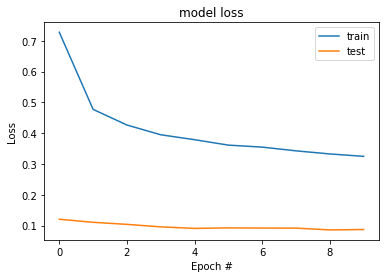

In [11]:
#losses_in_epochs = losses[:]
#plt.xkcd()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('model loss')
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

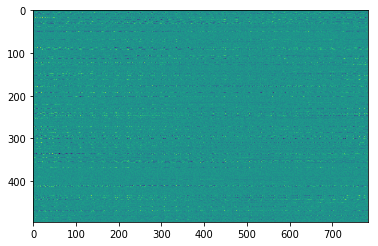

In [12]:
plt.imshow(FNN.fc1.weight.data)

In [18]:
print FNN.fc1.weight.data

tensor([[-4.5126e-03, -1.1880e-02,  2.5842e-02,  ..., -2.8407e-02,
          4.4774e-03, -9.9125e-03],
        [ 3.0074e-03, -8.4704e-03, -2.2617e-03,  ..., -5.6048e-03,
          1.0959e-02,  8.4237e-03],
        [-1.1341e-02,  2.4197e-02, -3.8283e-03,  ...,  2.5504e-02,
         -3.1405e-03,  3.3301e-02],
        ...,
        [ 2.2104e-02, -1.7041e-02, -1.9041e-02,  ..., -1.9114e-02,
         -1.0639e-02,  1.5990e-02],
        [ 6.1892e-02, -2.5704e-02, -7.9929e-02,  ..., -4.6403e-02,
         -1.6474e-02, -4.1970e-02],
        [-1.4274e-02,  3.9415e-02, -8.8972e-02,  ...,  1.0766e-01,
         -1.0624e-01, -2.9120e-02]])
